<a href="https://colab.research.google.com/github/FaridRash/IGNIS/blob/main/MA_SNR_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from ipywidgets import interact, FloatSlider

#Github

In [2]:
!git clone https://github.com/FaridRash/IGNIS

Cloning into 'IGNIS'...
remote: Enumerating objects: 369, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 369 (delta 83), reused 72 (delta 23), pack-reused 204 (from 1)
Receiving objects: 100% (369/369), 44.42 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Updating files: 100% (47/47), done.


In [3]:
!rm -rf /content/IGNIS/FoV\ visualization
!rm -rf /content/IGNIS/Notebooks/
!rm -rf /content/IGNIS/Reports/
!rm -rf /content/IGNIS/Requests/
!rm -rf /content/IGNIS/SNR\ Visualization

#Dataset

In [4]:
df = pd.read_csv("/content/IGNIS/Dataset/df_excel_with_temperature.csv")
df.head()

,Altitude,Theta,Hour,Month,Day,GSD,North,South,West,East,Background Temperature
0,461.218874,21.299047,02:00,1,2,76.025089,40.829036,40.828186,14.144160,14.145534,286.143799
1,462.767619,12.416525,02:00,1,5,76.280377,40.829036,40.828186,14.144157,14.145531,287.206543
2,463.422734,14.037020,02:00,1,5,76.388363,40.829036,40.828186,14.144156,14.145530,287.206543
3,466.582339,22.475595,15:00,1,5,76.909177,40.829036,40.828186,14.144150,14.145524,288.963867
4,466.012605,13.759815,15:00,1,5,76.815265,40.829036,40.828186,14.144151,14.145525,288.963867


In [5]:
df['Altitude'] = df['Altitude'] * 1000

#Constants

In [6]:
c1 = 3.7418e8
c2 = 1.4388e4
h = 6.626e-34
c = 3e8

In [7]:
epsilon = 0.95
tau_0 = 0.89
eta = 0.7
t = 0.01
focal_length = 72.8
F_number = 1.05
D = (focal_length / F_number) / 1000
NEDT = 0.0441 # NEDT = 44.1mK
lambda_range = np.arange(8, 14.1, 0.1)
delta_lambda = 0.1

#Variables

In [8]:
tau_a = 0.5
Tt = 433.15
At = 100

#Functions

In [9]:
def compute_sT(T):
    M_lambda = c1 / (lambda_range**5 * (np.exp(c2 / (lambda_range * T)) - 1))
    E_lambda = epsilon * M_lambda
    S_lambda = lambda_range * E_lambda * tau_a * tau_0 * eta * delta_lambda
    S_sum = np.sum(S_lambda)
    return S_sum

In [10]:
def compute_s(R, theta_deg, A0, S_sum):
  cos_theta = np.cos(np.deg2rad(theta_deg))
  S_total = (D**2 * t * cos_theta * A0) / (4 * R**2 * h * c) * S_sum
  return S_total

#Sb

In [11]:
df["Background Area"] = df["GSD"]**2
df['Sum of Background'] = df['Background Temperature'].apply(compute_sT)
df["Background Signal"] = compute_s(df["Altitude"], df["Theta"], df["Background Area"], df["Sum of Background"])

#SNEDT

In [12]:
df["NEDT Temp"] = df["Background Temperature"] + NEDT
df['Sum of NEDT'] = df['NEDT Temp'].apply(compute_sT)
df["NEDT S"] = df['Sum of NEDT'] - df['Sum of Background']
df["NEDT Signal"] = compute_s(df["Altitude"], df["Theta"], df["Background Area"], df["NEDT S"])

#Smix

In [13]:
s_Tt= compute_sT(Tt)
print(f'St: {s_Tt:.2f}')

St: 2322.84


In [14]:
df["Target Signal"] = compute_s(df["Altitude"], df["Theta"], 100, s_Tt)
df["Mix Signal"] = (df["Background Signal"] * (1 - (At/df['Background Area']))) + df["Target Signal"]

#SNR

In [15]:
df["SNR"] = (df["Mix Signal"] - df['Background Signal']) / df["NEDT Signal"]

#Visualization

In [16]:
top_10_snr = df.nlargest(10, 'SNR')
print(top_10_snr[['Altitude', 'Theta', 'Hour', 'Day', 'Month',  'Background Temperature',  'SNR']])

           Altitude      Theta   Hour  Day  Month  Background Temperature  \
1124  200498.988550  30.063427  03:00   23      9              292.987305   
1125  200879.079888  34.380576  03:00   23      9              292.987305   
1123  216994.808789  38.488131  16:00   21      9              295.946045   
1122  217520.348261  31.291111  16:00   21      9              295.946045   
1121  239493.478277   5.665667  03:00   18      9              292.074219   
1120  244791.723498  33.771153  16:00   16      9              294.028076   
1119  248021.537369  22.927472  16:00   15      9              295.453125   
1118  248510.443723  32.972566  16:00   15      9              295.453125   
1116  269170.008125  35.842732  03:00    7      9              297.895020   
1117  269607.897047  28.672916  03:00    7      9              297.895020   

             SNR  
1124  477.936656  
1125  476.129721  
1123  391.936228  
1122  390.044642  
1121  339.167203  
1120  316.115627  
1119  302.025710  


In [17]:
bottom_10_snr = df.nsmallest(10, 'SNR')
print(bottom_10_snr[['Altitude', 'Theta', 'Hour', 'Day', 'Month',  'Background Temperature', 'SNR']])

          Altitude      Theta   Hour  Day  Month  Background Temperature  \
125  457301.197415  14.332015  15:00   29      7              303.256348   
117  461676.520041  14.821779  15:00   16      7              301.649902   
126  456669.357025  15.628523  15:00   29      7              303.256348   
118  461235.989387  16.810330  15:00   16      7              301.649902   
131  461127.533195  17.674909  02:00   11      8              301.613525   
130  460787.860901  14.778970  02:00   11      8              301.613525   
113  461772.338387  10.082570  15:00   11      7              301.280518   
114  461426.098923  22.925995  15:00   11      7              301.280518   
132  449799.996464   5.236456  15:00   11      8              304.031982   
133  449145.284722  21.605575  15:00   11      8              304.031982   

           SNR  
125  79.923884  
117  80.140503  
126  80.145200  
118  80.293662  
131  80.371017  
130  80.489553  
113  80.508968  
114  80.629836  
132  81.74

In [18]:
fig = px.scatter_3d(df, x='Theta', y='Altitude', z="SNR",
                    color="SNR", title="SNR vs Theta and Altitude")
fig.show()


<Figure size 1000x600 with 0 Axes>

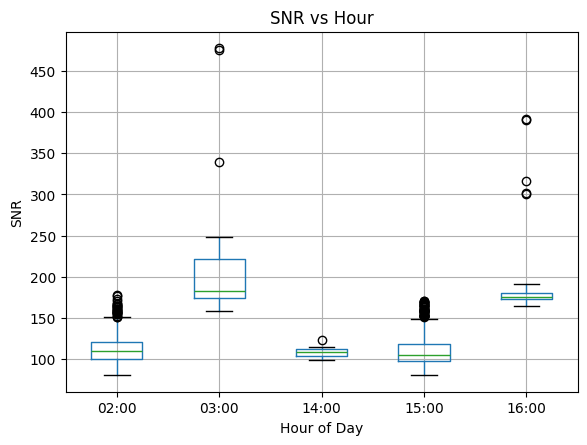

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df.boxplot(column='SNR', by='Hour')
plt.title('SNR vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('SNR')
plt.suptitle('')
plt.show()

<Figure size 1000x600 with 0 Axes>

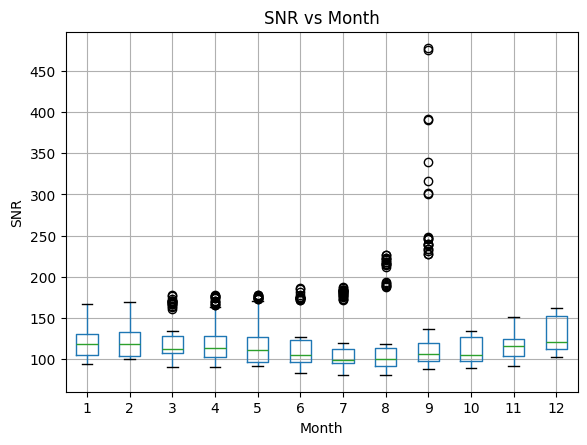

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df.boxplot(column='SNR', by='Month')
plt.title('SNR vs Month')
plt.xlabel('Month')
plt.ylabel('SNR')
plt.suptitle('')
plt.show()

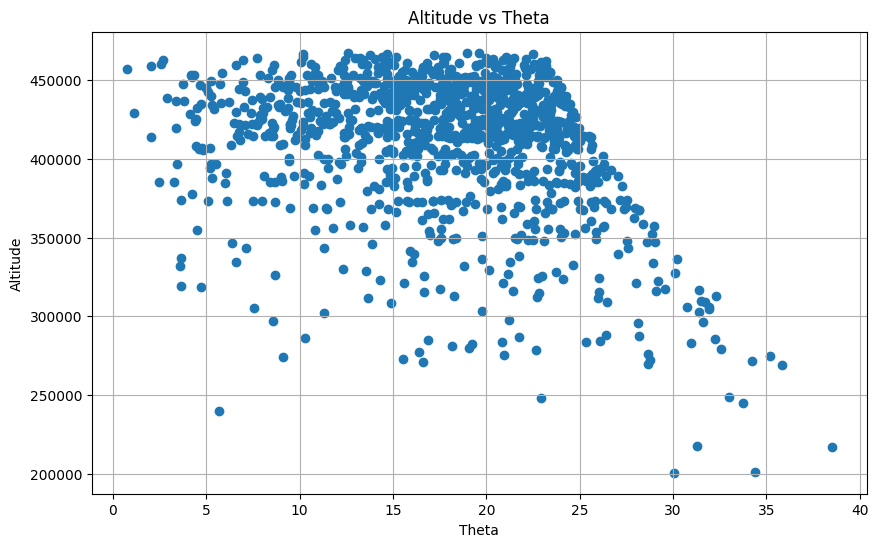

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df['Theta'], df['Altitude'])
plt.xlabel('Theta')
plt.ylabel('Altitude')
plt.title('Altitude vs Theta')
plt.grid(True)
plt.show()

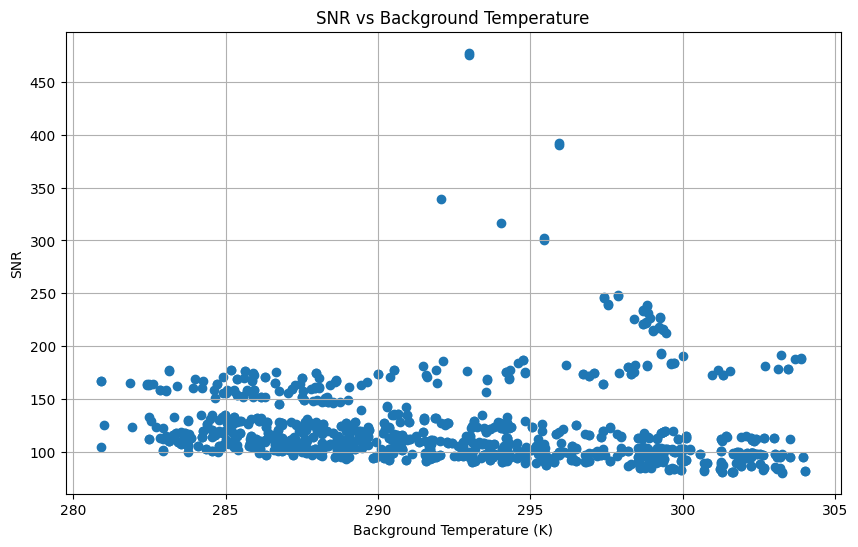

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df['Background Temperature'], df['SNR'])
plt.xlabel('Background Temperature (K)')
plt.ylabel('SNR')
plt.title('SNR vs Background Temperature')
plt.grid(True)
plt.show()